In [1]:
import sys
import importlib

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import numba

from functions import sensitivity_map, mlem, osem

plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.dpi'] = 100
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['font.size'] = 15

In [2]:
import functions
importlib.reload(functions)
from functions import sensitivity_map, mlem, osem

# Constants

In [3]:
collimator = dict(distance=250, angle=6, direction=60, number=306, todetector=4.37, diameter=1.5, interval=0.2, thickness=35)
detector = dict(number=128, width=4.0625, length=520, depth=9.5)
image = dict(pixels=128, width=4.0625)

In [4]:
x_pixels = np.arange(-image['pixels'] / 2 * image['width'] + image['width'] / 2, image['pixels'] / 2 * image['width'] + image['width'] / 2, image['width'])

X_pixels, Y_pixels = np.meshgrid(x_pixels, x_pixels)

In [5]:
x_pixels_wall = np.linspace(-image['pixels'] * image['width'] / 2, image['pixels'] * image['width'] / 2, image['pixels'] + 1)

y_pixels_wall = x_pixels_wall.copy()

pixels_wall = [x_pixels_wall, y_pixels_wall]

In [6]:
hotxy = np.array([[100, 0], [50, 86.6], [-50, 86.6], [-100, 0], [-50, -86.6], [50, -86.6]])

hotr = np.arange(8, 48 + 1, 8)

C = 5

vali = [np.sqrt((X_pixels - hotxy[j][0]) ** 2 + (Y_pixels - hotxy[j][1]) ** 2) < hotr[j] for j in range(6)]

bkgvali = np.sqrt(X_pixels ** 2 + Y_pixels ** 2) < 15 * image['width']

In [7]:
[vali[j].sum() for j in range(6)]

[14, 49, 110, 194, 303, 435]

In [8]:
x_num = np.array([[1, image['pixels']]]).T

In [9]:
def CRC(gray):
    return np.array([(gray[vali[j]].mean() - gray[bkgvali].mean()) / gray[vali[j]].mean() / (C - 1) for j in range(6)])

def CNR(gray):
    return np.array([(gray[vali[j]].mean() - gray[bkgvali].mean()) / gray[vali[j]].std() for j in range(6)])

# Transformation matrix

In [10]:
mu = 0.1538 * 1 #cm-1

In [11]:
def trans_matrix(method='delta'):
    matrix = np.zeros((detector['number'] * collimator['direction'], image['pixels'] ** 2))#.astype(np.float32)
    distance = collimator['distance'] + collimator['todetector'] + collimator['thickness']
    if method == 'delta':
        for i in range(collimator['direction']):
            theta = i * collimator['angle'] / 180 * np.pi + 1e-8
            m = np.zeros((detector['number'], image['pixels'] ** 2))
            k = np.tan(theta)
            t_c = np.arange(-detector['number'] / 2 * detector['width'], detector['number'] / 2 * detector['width'] + 1e-8, detector['width'])
            x_o = np.cos(theta) * distance
            y_o = np.sin(theta) * distance
            x_c = np.cos(theta + np.pi / 2) * t_c + x_o
            y_c = np.sin(theta + np.pi / 2) * t_c + y_o
            b = y_c - k * x_c
            slit = np.digitize(Y_pixels.flatten() - k * X_pixels.flatten(), b) - 1
            for j, s in enumerate(slit):
                if s >= 0 and s < detector['number']:
                    m[s, j] = 1
            matrix[detector['number'] * i:detector['number'] * (i+1)] = m
    elif method == 'Siddon':
        for i in range(collimator['direction']):
            theta = i * collimator['angle'] / 180 * np.pi + 1e-8
            m = np.zeros((detector['number'], image['pixels'] ** 2))
            k = np.tan(theta)
            x_o = np.cos(theta) * distance
            y_o = np.sin(theta) * distance
            x_i = np.cos(theta + np.pi / 2) * x_pixels
            y_i = np.sin(theta + np.pi / 2) * x_pixels
            x_c = np.cos(theta + np.pi / 2) * x_pixels + x_o
            y_c = np.sin(theta + np.pi / 2) * x_pixels + y_o
            x_d = 2 * x_i - x_c
            y_d = 2 * y_i - y_c
            xy = np.vstack([x_c, y_c, x_d, y_d]).T
            for j, xyi in enumerate(xy):
                idx, d = sensitivity_map(xyi, pixels_wall, x_num)
                m[j, idx] = d
            matrix[detector['number'] * i:detector['number'] * (i+1)] = m
    elif method == 'Siddon-decay':
        width = 2 * detector['number'] * detector['width']
        for i in range(collimator['direction']):
            theta = i * collimator['angle'] / 180 * np.pi + 1e-8
            m = np.zeros((detector['number'], image['pixels'] ** 2))
            k = np.tan(theta)
            x_o = np.cos(theta) * distance
            y_o = np.sin(theta) * distance
            x_i = np.cos(theta + np.pi / 2) * x_pixels
            y_i = np.sin(theta + np.pi / 2) * x_pixels
            x_c = np.cos(theta + np.pi / 2) * x_pixels + x_o
            y_c = np.sin(theta + np.pi / 2) * x_pixels + y_o
            x_d = 2 * x_i - x_c
            y_d = 2 * y_i - y_c
            xy = np.vstack([x_c, y_c, x_d, y_d]).T
            for j, xyi in enumerate(xy):
                idx, s = sensitivity_map(xyi, pixels_wall, x_num)
                d = np.sqrt((X_pixels - xyi[0]) ** 2 + (Y_pixels - xyi[1]) ** 2).flatten()
                # m[j, idx] = s * np.exp(-d[idx] / 10 * mu) * 10
                m[j, idx] = s * (width - d[idx]) / width
            matrix[detector['number'] * i:detector['number'] * (i+1)] = m
    elif method == 'Siddon-vague':
        width = 2 * detector['number'] * detector['width']
        for i in range(collimator['direction']):
            theta = i * collimator['angle'] / 180 * np.pi + 1e-8
            m = np.zeros((detector['number'], image['pixels'] ** 2))
            k = np.tan(theta)
            x_o = np.cos(theta) * distance
            y_o = np.sin(theta) * distance
            x_i = np.cos(theta + np.pi / 2) * x_pixels
            y_i = np.sin(theta + np.pi / 2) * x_pixels
            x_c = np.cos(theta + np.pi / 2) * x_pixels + x_o
            y_c = np.sin(theta + np.pi / 2) * x_pixels + y_o
            x_d = 2 * x_i - x_c
            y_d = 2 * y_i - y_c
            xy = np.vstack([x_c, y_c, x_d, y_d]).T
            for j, xyi in enumerate(xy):
                idx, s = sensitivity_map(xyi, pixels_wall, x_num)
                m[j, idx] += s
                d = np.sqrt((X_pixels - xyi[0]) ** 2 + (Y_pixels - xyi[1]) ** 2).flatten()
                if j - 1 >= 0:
                    idx, s = sensitivity_map(xy[j-1], pixels_wall, x_num)
                    m[j, idx] += s * d[idx] / width
                if j + 1 < len(xy):
                    idx, s = sensitivity_map(xy[j+1], pixels_wall, x_num)
                    m[j, idx] += s * d[idx] / width
            matrix[detector['number'] * i:detector['number'] * (i+1)] = m
    return matrix

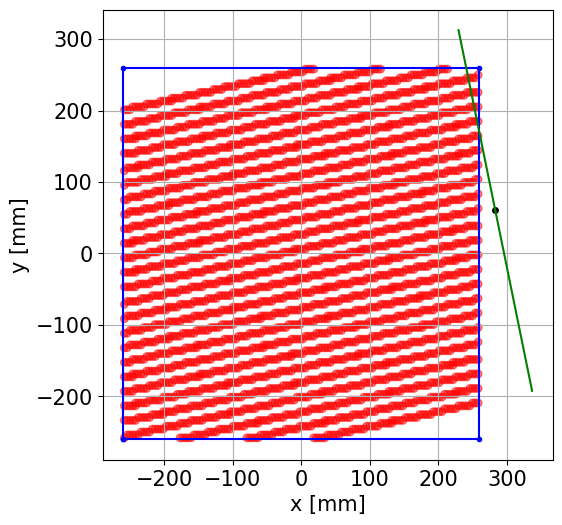

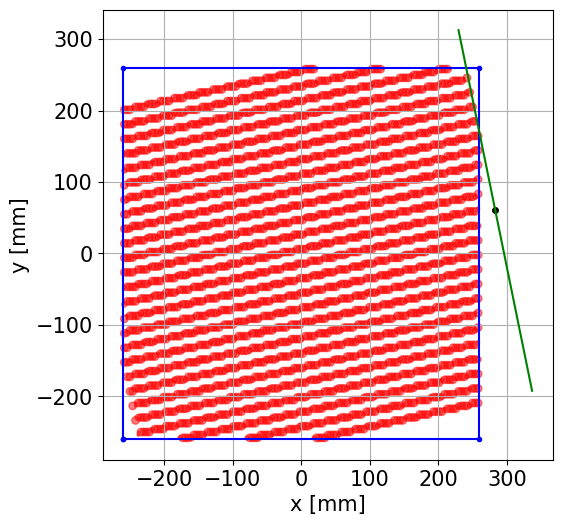

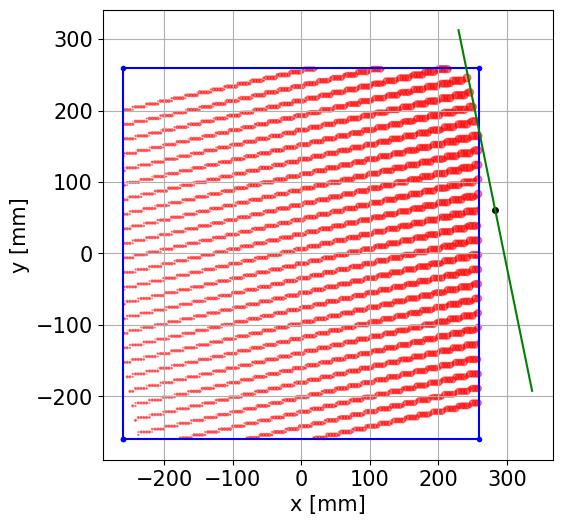

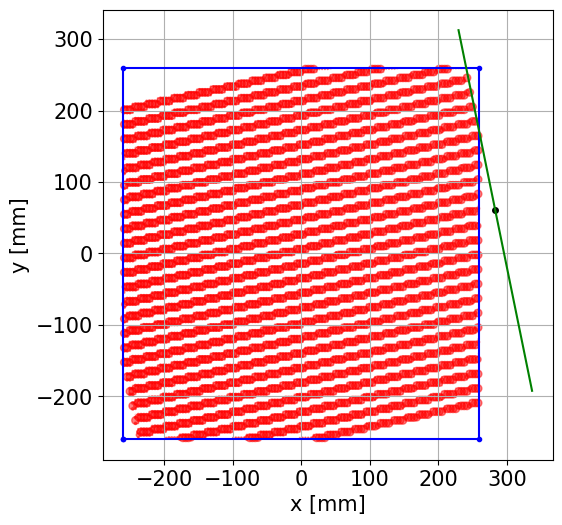

In [12]:
for method in ['delta', 'Siddon', 'Siddon-decay', 'Siddon-vague']:
    m = trans_matrix(method=method)

    distance = collimator['distance'] + collimator['todetector'] + collimator['thickness']

    fig = plt.figure(figsize=(6, 6))
    # fig.tight_layout()
    gs = gridspec.GridSpec(1, 1, figure=fig, left=0.2, right=0.95, top=0.95, bottom=0.2, wspace=0.3, hspace=0.3)
    ax = fig.add_subplot(gs[0, 0])
    mmin = m[2 * detector['number']:3 * detector['number'], :][m[2 * detector['number']:3 * detector['number'], :] != 0].min()
    mmax = (m[2 * detector['number']:3 * detector['number'], :] / mmin).max()
    for j in np.arange(2 * detector['number'], 3 * detector['number'], 5):
        ax.scatter(X_pixels.flatten(), Y_pixels.flatten(), c='r', s=(np.exp(m[j, :] / mmin / mmax * 5) - 1) / 5, alpha=0.5)
    d = detector['number'] * detector['width']
    theta = 2 * collimator['angle'] / 180 * np.pi + 1e-8
    ax.plot([-d/2, -d/2, d/2, d/2, -d/2], [-d/2, d/2, d/2, -d/2, -d/2], '.-', color='b')
    t_c = np.arange(-detector['number'] / 2 * detector['width'], detector['number'] / 2 * detector['width'] + 1e-8, detector['width'])
    x_o = np.cos(theta) * distance
    y_o = np.sin(theta) * distance
    x_i = np.cos(theta + np.pi / 2) * x_pixels
    y_i = np.sin(theta + np.pi / 2) * x_pixels
    x_c = np.cos(theta + np.pi / 2) * x_pixels + x_o
    y_c = np.sin(theta + np.pi / 2) * x_pixels + y_o
    x_d = 2 * x_i - x_c
    y_d = 2 * y_i - y_c
    ax.plot(x_c, y_c, c='g')
    # ax.plot(x_d, y_d, c='g')
    ax.scatter(x_o, y_o, c='k', s=16.)
    ax.grid()
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('y [mm]')
    fig.savefig('img/{}_cij.png'.format(method))

    plt.show()

# ML-EM reconstruction

In [13]:
p = np.fromfile('Proj_1e7Counts', dtype=np.float32)

m = trans_matrix(method='Siddon')

In [14]:
f_list, d_list = mlem(p, m, iteration=200)

gray = f_list[-1].reshape((image['pixels'], image['pixels']))[::-1, ::-1]

100%|██████████| 200/200 [00:37<00:00,  5.31it/s]


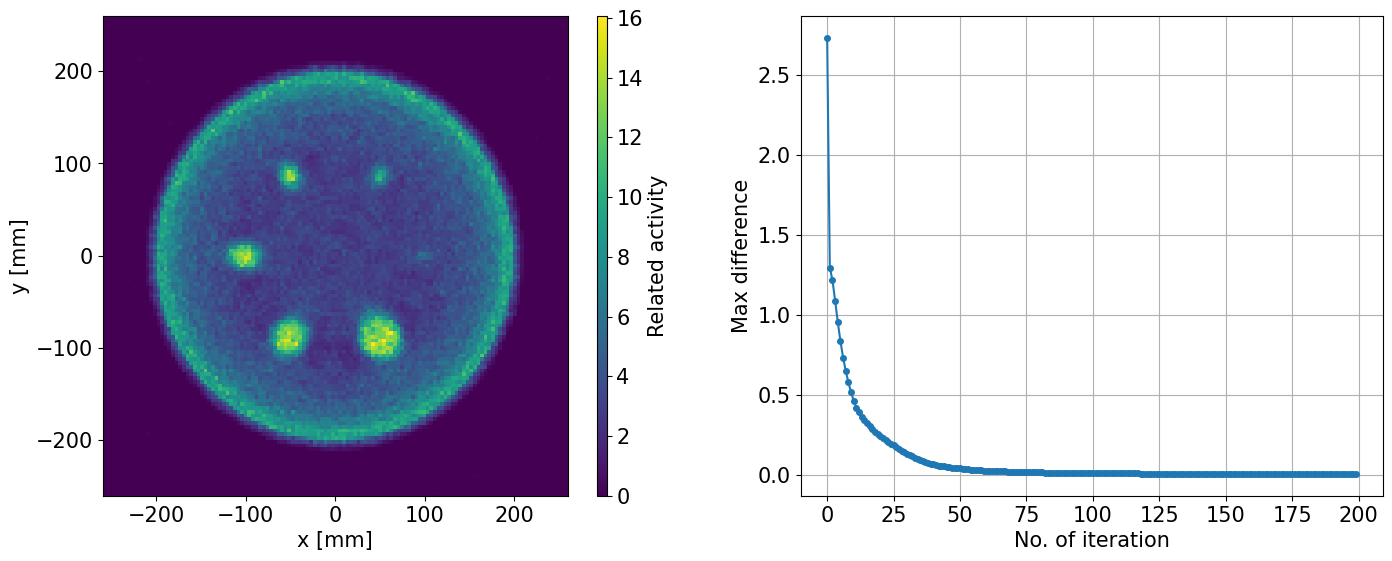

In [15]:
fig = plt.figure(figsize=(16, 6))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 2, figure=fig, left=0.15, right=0.95, top=0.95, bottom=0.15, wspace=0.2, hspace=0.3)
ax = fig.add_subplot(gs[0, 0])
pc = ax.pcolormesh(X_pixels, Y_pixels, gray, shading='auto')
c = fig.colorbar(pc, ax=ax, aspect=50)
c.ax.set_ylabel('Related activity')
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')

ax = fig.add_subplot(gs[0, 1])
ax.plot(np.arange(len(d_list)), d_list, 'o-', markersize=4.0)
ax.grid()
ax.set_xlabel('No. of iteration')
ax.set_ylabel('Max difference')

plt.savefig('img/C7_mlem_recon.png')

plt.show()

# OS-EM reconstruction

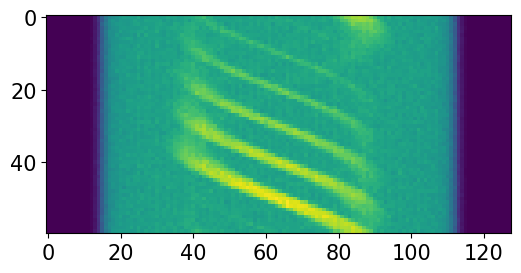

In [16]:
p = np.fromfile('Proj_1e7Counts', dtype=np.float32)

plt.imshow(p.reshape((collimator['direction'], image['pixels'])))

plt.savefig('img/origin.png')

plt.show()

In [17]:
L_list = np.array([1, 2, 4, 6, 10, 15, 30])

100%|██████████| 50/50 [00:09<00:00,  5.03it/s]


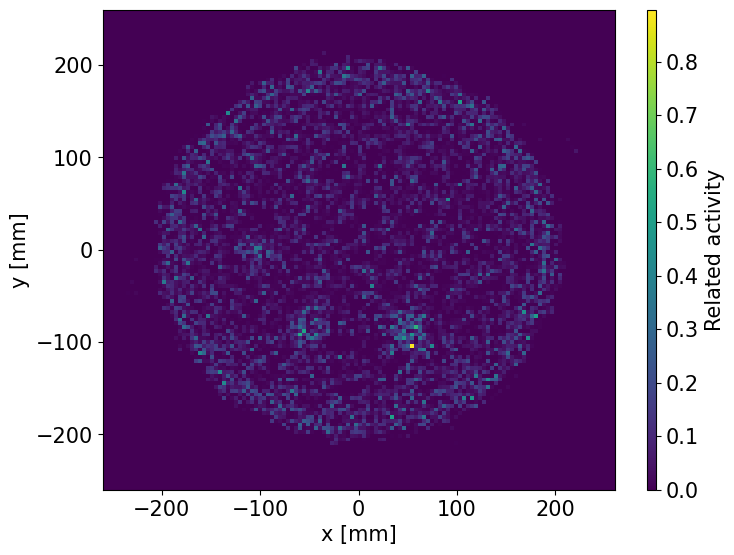

100%|██████████| 50/50 [00:09<00:00,  5.07it/s]


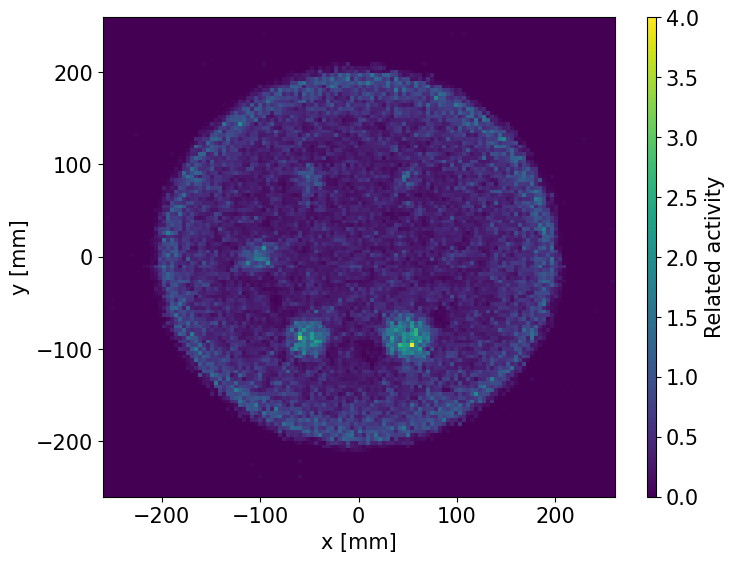

100%|██████████| 50/50 [00:09<00:00,  5.09it/s]


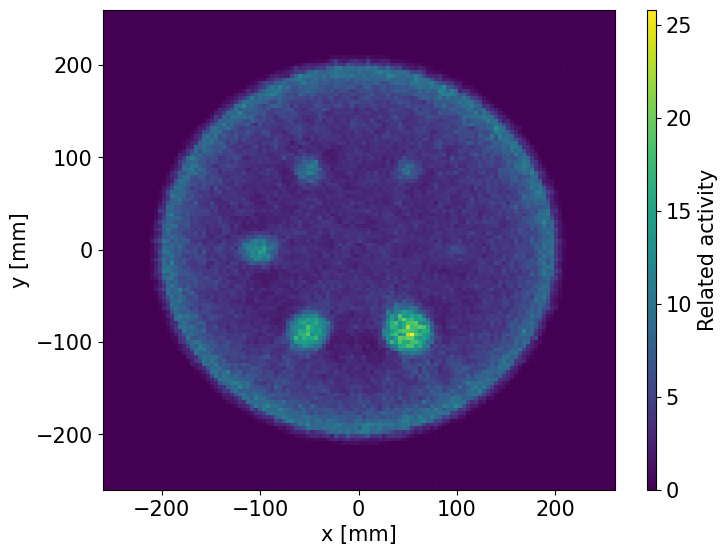

In [18]:
m = trans_matrix(method='Siddon')

for ci in [5, 6, 7]:
    p = np.fromfile('Proj_1e{}Counts'.format(ci), dtype=np.float32)

    L = L_list[4]
    iteration = 50
    f_list, d_list = osem(p, m, iteration, L)

    gray = f_list[-1].reshape((image['pixels'], image['pixels']))[::-1, ::-1]
    
    fig = plt.figure(figsize=(8, 6))
    # fig.tight_layout()
    gs = gridspec.GridSpec(1, 1, figure=fig, left=0.15, right=0.95, top=0.95, bottom=0.15, wspace=0.3, hspace=0.3)
    ax = fig.add_subplot(gs[0, 0])
    pc = ax.pcolormesh(X_pixels, Y_pixels, gray, shading='auto')
    c = fig.colorbar(pc, ax=ax, aspect=50)
    c.ax.set_ylabel('Related activity')
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('y [mm]')

    fig.savefig('img/C{}_osem_recon.png'.format(ci))

    plt.show()

100%|██████████| 50/50 [00:09<00:00,  5.03it/s]


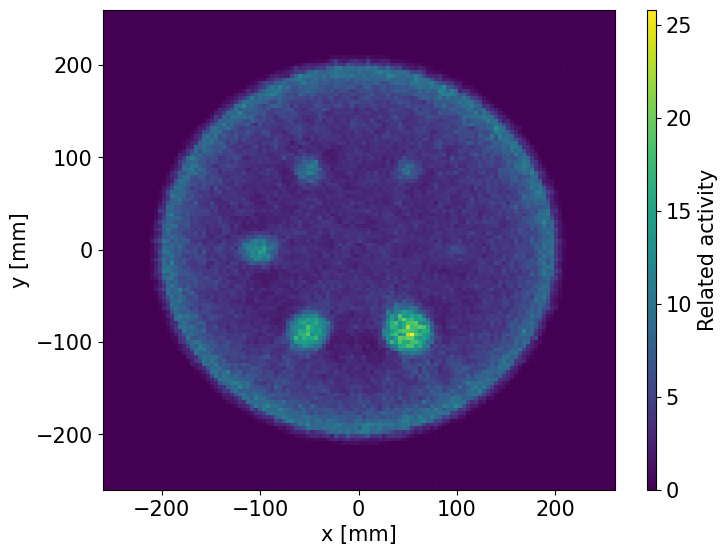

100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


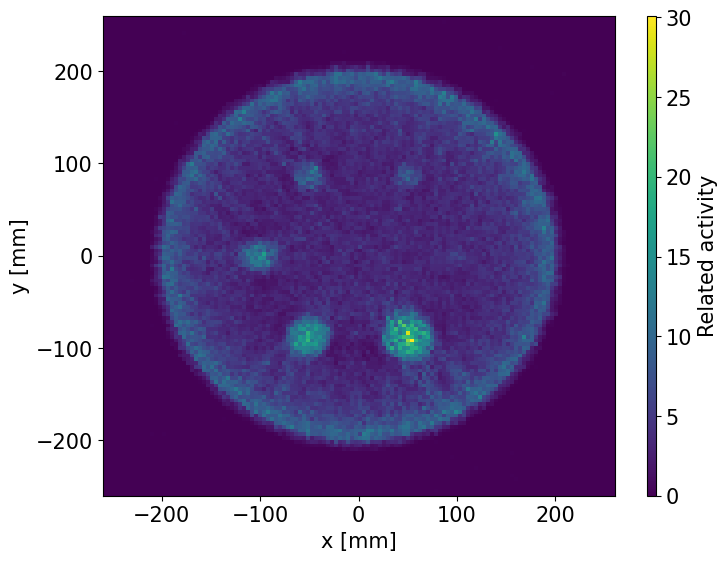

100%|██████████| 150/150 [00:29<00:00,  5.06it/s]


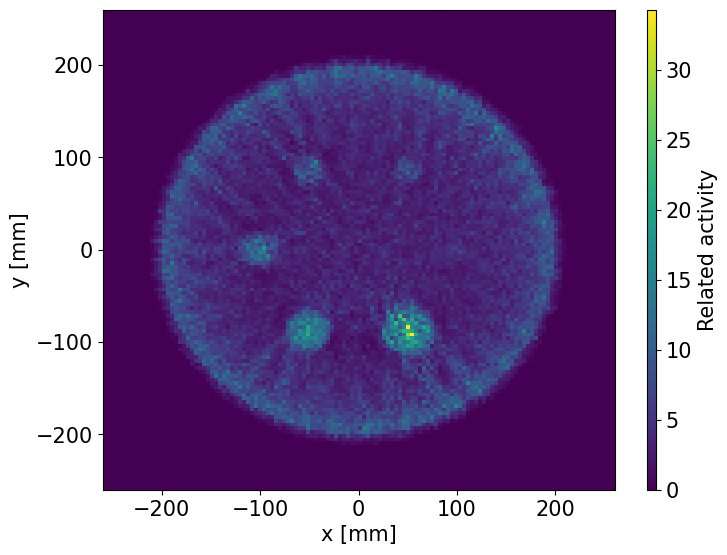

100%|██████████| 200/200 [00:42<00:00,  4.69it/s]


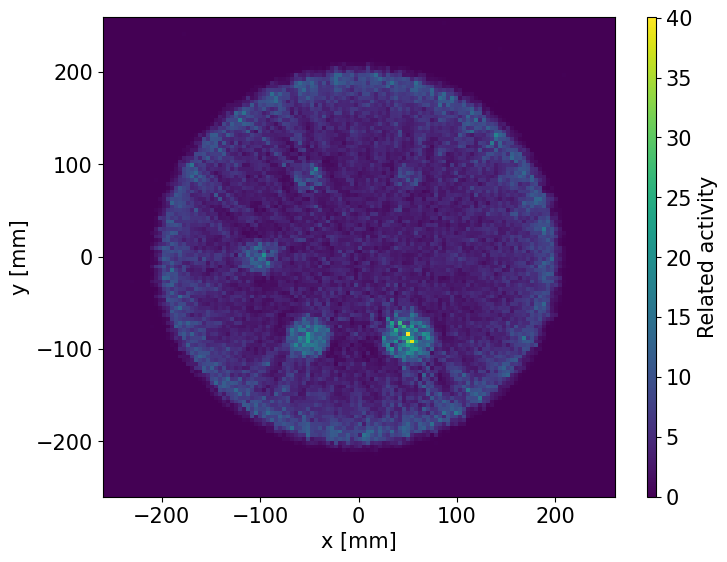

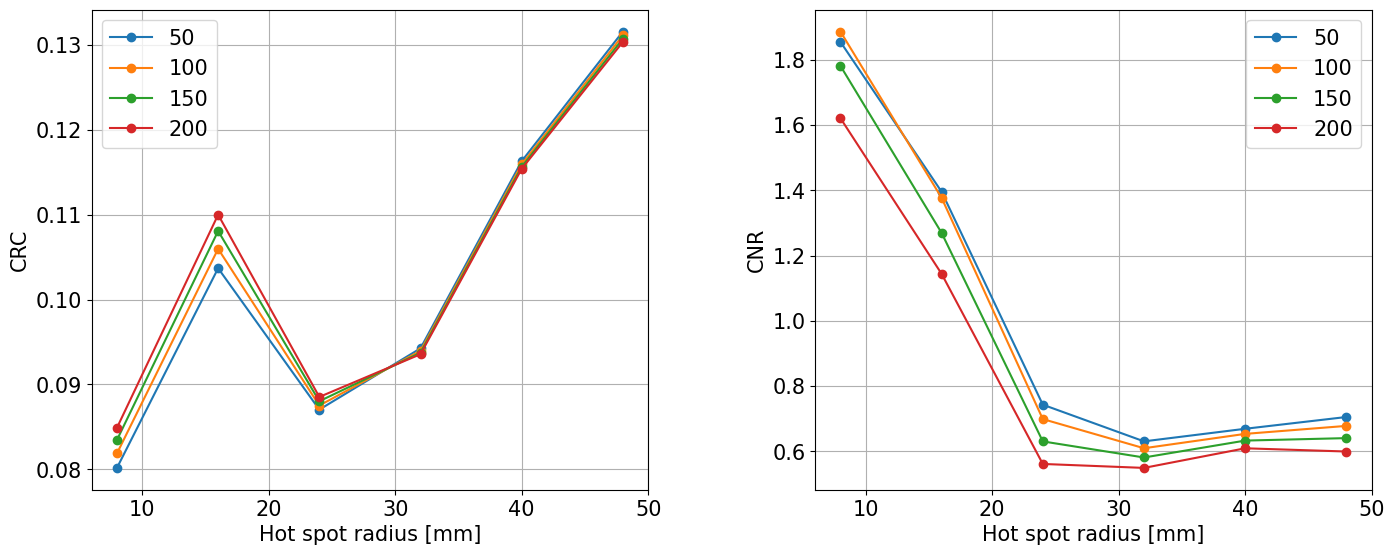

In [19]:
CRC_list = []
CNR_list = []

p = np.fromfile('Proj_1e7Counts', dtype=np.float32)
f = np.full(image['pixels'] ** 2, p.sum() / m.sum()).astype(np.float32)

iter_list = [50, 100, 150, 200]

for ci in iter_list:
    L = L_list[4]
    f_list, d_list = osem(p, m, ci, L)
    gray = f_list[-1].reshape((image['pixels'], image['pixels']))[::-1, ::-1]
    
    CRC_list.append(CRC(gray))
    CNR_list.append(CNR(gray))
    
    fig = plt.figure(figsize=(8, 6))
    # fig.tight_layout()
    gs = gridspec.GridSpec(1, 1, figure=fig, left=0.15, right=0.95, top=0.95, bottom=0.15, wspace=0.3, hspace=0.3)
    ax = fig.add_subplot(gs[0, 0])
    pc = ax.pcolormesh(X_pixels, Y_pixels, gray, shading='auto')
    c = fig.colorbar(pc, ax=ax, aspect=50)
    c.ax.set_ylabel('Related activity')
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('y [mm]')

    fig.savefig('img/C7_iter{:03d}_osem_recon.png'.format(ci))

    plt.show()

fig = plt.figure(figsize=(16, 6))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 2, figure=fig, left=0.15, right=0.95, top=0.95, bottom=0.15, wspace=0.3, hspace=0.3)
ax = fig.add_subplot(gs[0, 0])
for i, ci in enumerate(iter_list):
    ax.plot(hotr, CRC_list[i], 'o-', label=ci)
ax.grid()
ax.set_xlabel('Hot spot radius [mm]')
ax.set_ylabel('CRC')
ax.legend()

ax = fig.add_subplot(gs[0, 1])
for i, ci in enumerate(iter_list):
    ax.plot(hotr, CNR_list[i], 'o-', label=ci)
ax.grid()
ax.set_xlabel('Hot spot radius [mm]')
ax.set_ylabel('CNR')
ax.legend()

fig.savefig('img/C7-iter-crccnr.png')

plt.show()

100%|██████████| 100/100 [00:21<00:00,  4.76it/s]


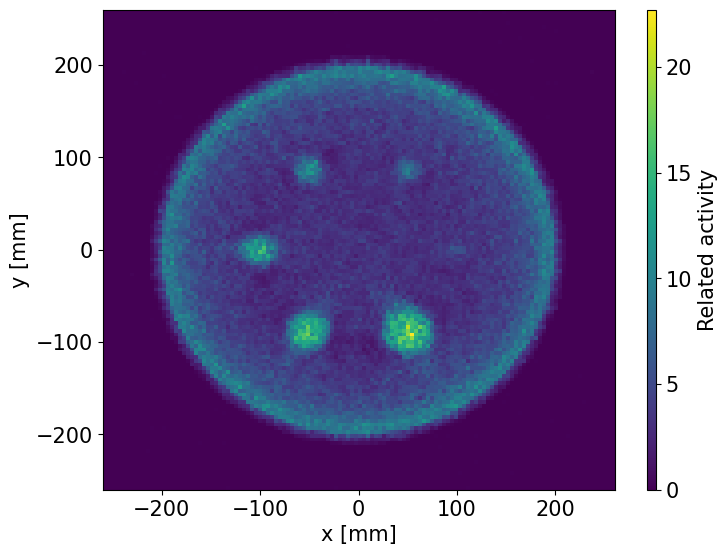

100%|██████████| 100/100 [00:20<00:00,  4.91it/s]


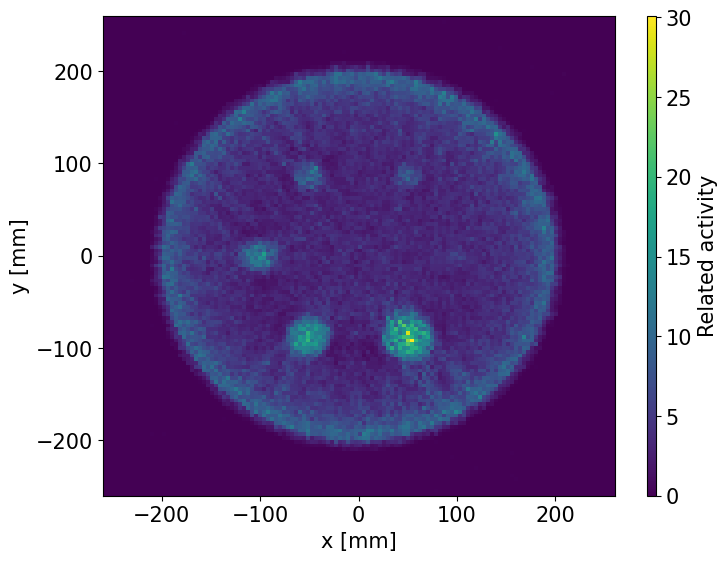

100%|██████████| 100/100 [00:19<00:00,  5.05it/s]


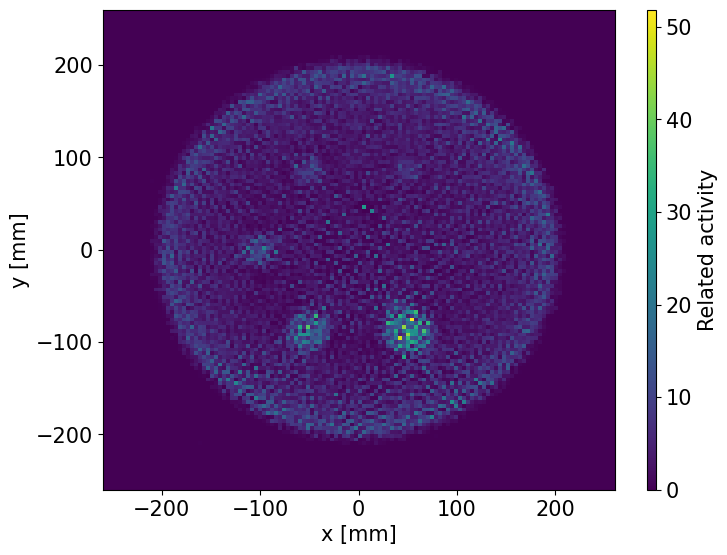

100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


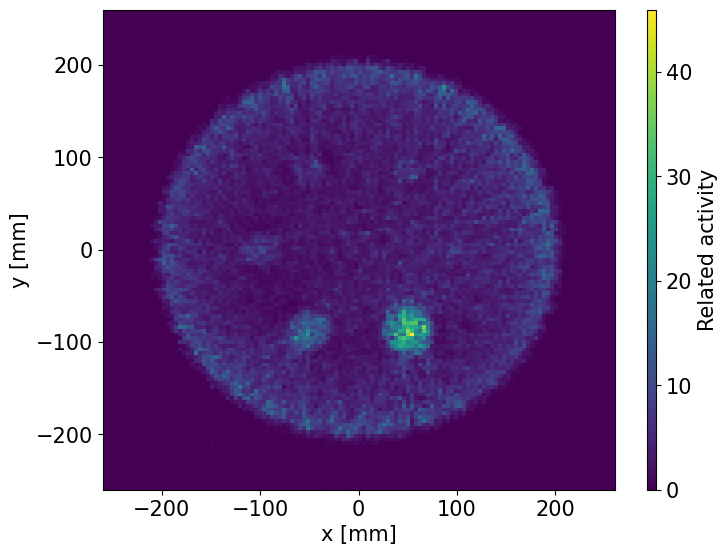

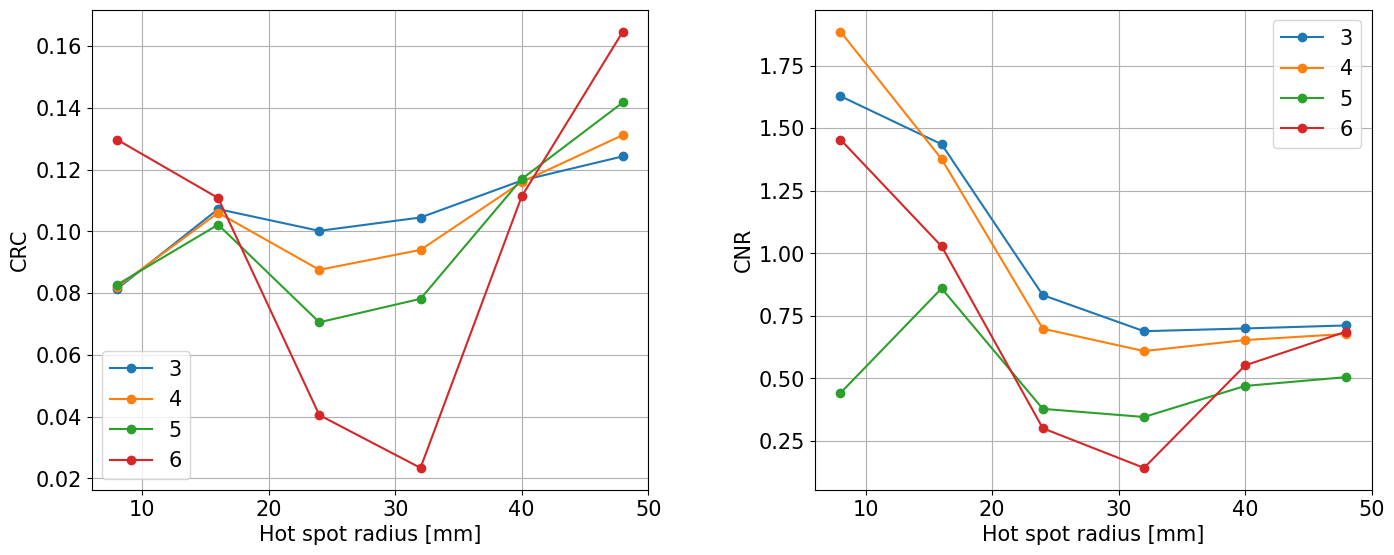

In [20]:
CRC_list = []
CNR_list = []

L_list_idx = [3, 4, 5, 6]

for i in L_list_idx:
    L = L_list[i]
    f_list, d_list = osem(p, m, 100, L)
    gray = f_list[-1].reshape((image['pixels'], image['pixels']))[::-1, ::-1]
    
    fig = plt.figure(figsize=(8, 6))
    # fig.tight_layout()
    gs = gridspec.GridSpec(1, 1, figure=fig, left=0.15, right=0.95, top=0.95, bottom=0.15, wspace=0.3, hspace=0.3)
    ax = fig.add_subplot(gs[0, 0])
    pc = ax.pcolormesh(X_pixels, Y_pixels, gray, shading='auto')
    c = fig.colorbar(pc, ax=ax, aspect=50)
    c.ax.set_ylabel('Related activity')
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('y [mm]')
    fig.savefig('img/C7_L{:02d}_osem_recon.png'.format(L))

    plt.show()
    CRC_list.append(CRC(gray))
    CNR_list.append(CNR(gray))

fig = plt.figure(figsize=(16, 6))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 2, figure=fig, left=0.15, right=0.95, top=0.95, bottom=0.15, wspace=0.3, hspace=0.3)
ax = fig.add_subplot(gs[0, 0])
for i, L in enumerate(L_list_idx):
    ax.plot(hotr, CRC_list[i], 'o-', label=L)
ax.grid()
ax.set_xlabel('Hot spot radius [mm]')
ax.set_ylabel('CRC')
ax.legend()

ax = fig.add_subplot(gs[0, 1])
for i, L in enumerate(L_list_idx):
    ax.plot(hotr, CNR_list[i], 'o-', label=L)
ax.grid()
ax.set_xlabel('Hot spot radius [mm]')
ax.set_ylabel('CNR')
ax.legend()

fig.savefig('img/C7-L-crccnr.png')

plt.show()

100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


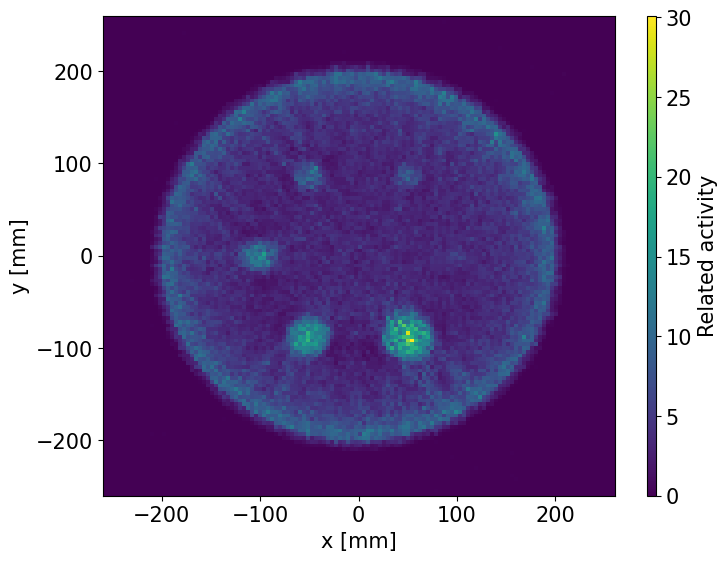

100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


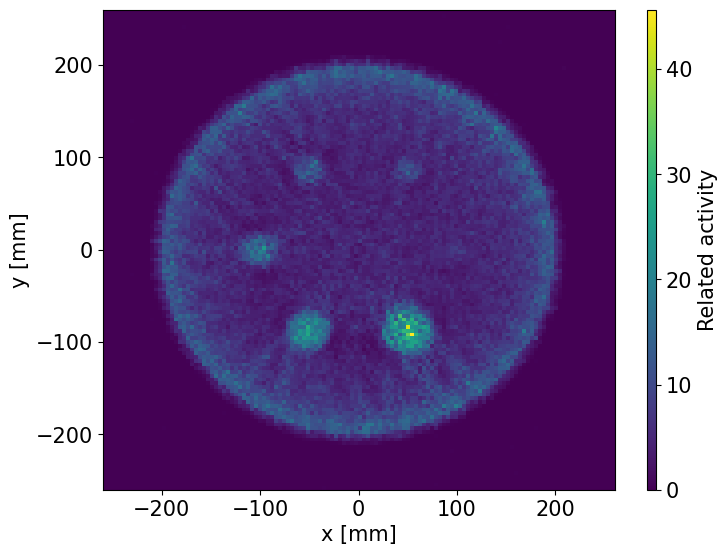

100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


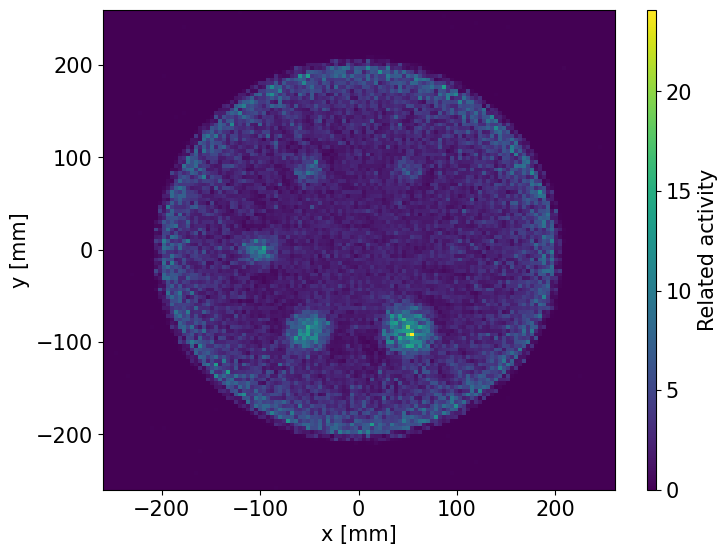

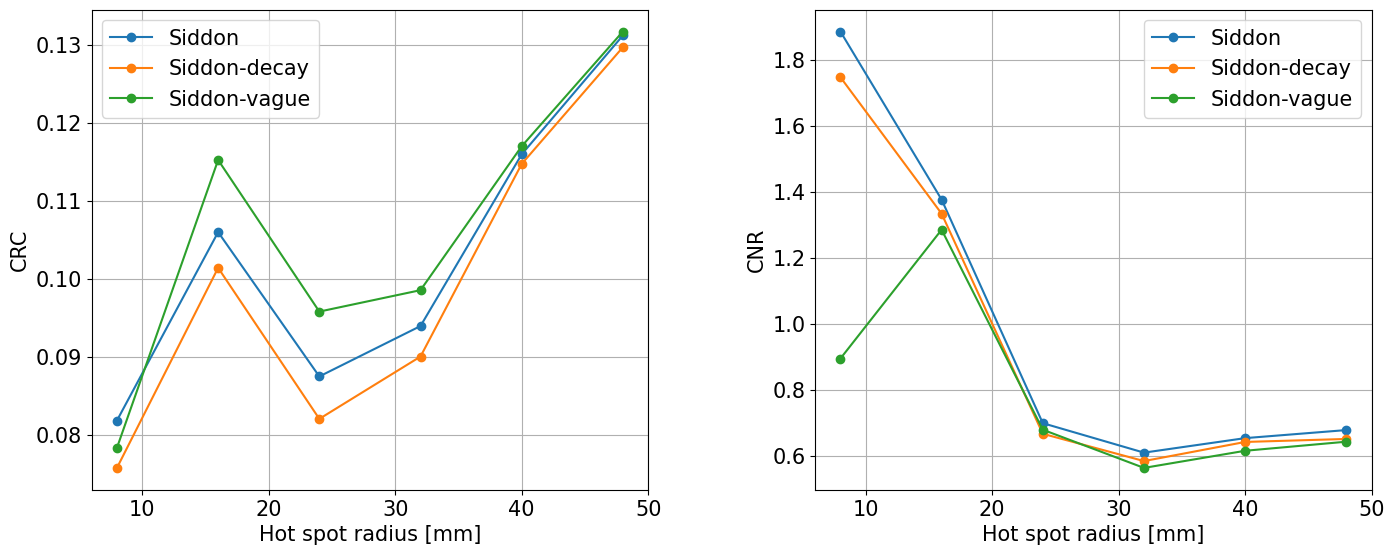

In [21]:
CRC_list = []
CNR_list = []

method_list = ['Siddon', 'Siddon-decay', 'Siddon-vague']

for method in method_list:
    m = trans_matrix(method=method)
    L = L_list[4]
    f_list, d_list = osem(p, m, 100, L)
    gray = f_list[-1].reshape((image['pixels'], image['pixels']))[::-1, ::-1]
    
    fig = plt.figure(figsize=(8, 6))
    # fig.tight_layout()
    gs = gridspec.GridSpec(1, 1, figure=fig, left=0.15, right=0.95, top=0.95, bottom=0.15, wspace=0.3, hspace=0.3)
    ax = fig.add_subplot(gs[0, 0])
    pc = ax.pcolormesh(X_pixels, Y_pixels, gray, shading='auto')
    c = fig.colorbar(pc, ax=ax, aspect=50)
    c.ax.set_ylabel('Related activity')
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('y [mm]')
    fig.savefig('img/C7_{}_recon'.format(method))

    plt.show()
    CRC_list.append(CRC(gray))
    CNR_list.append(CNR(gray))

fig = plt.figure(figsize=(16, 6))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 2, figure=fig, left=0.15, right=0.95, top=0.95, bottom=0.15, wspace=0.3, hspace=0.3)
ax = fig.add_subplot(gs[0, 0])
for i, mi in enumerate(method_list):
    ax.plot(hotr, CRC_list[i], 'o-', label=mi)
ax.grid()
ax.set_xlabel('Hot spot radius [mm]')
ax.set_ylabel('CRC')
ax.legend()

ax = fig.add_subplot(gs[0, 1])
for i, mi in enumerate(method_list):
    ax.plot(hotr, CNR_list[i], 'o-', label=mi)
ax.grid()
ax.set_xlabel('Hot spot radius [mm]')
ax.set_ylabel('CNR')
ax.legend()

fig.savefig('img/C7-method-crccnr.png')

plt.show()

100%|██████████| 50/50 [00:09<00:00,  5.17it/s]


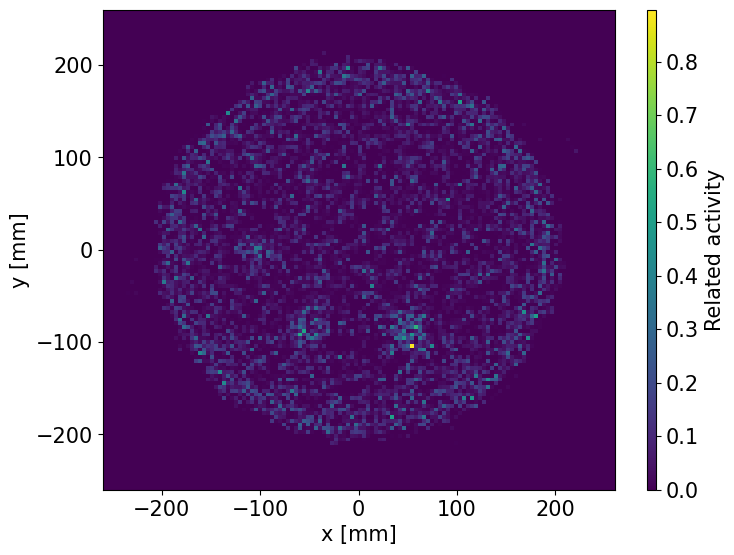

100%|██████████| 200/200 [00:38<00:00,  5.24it/s]


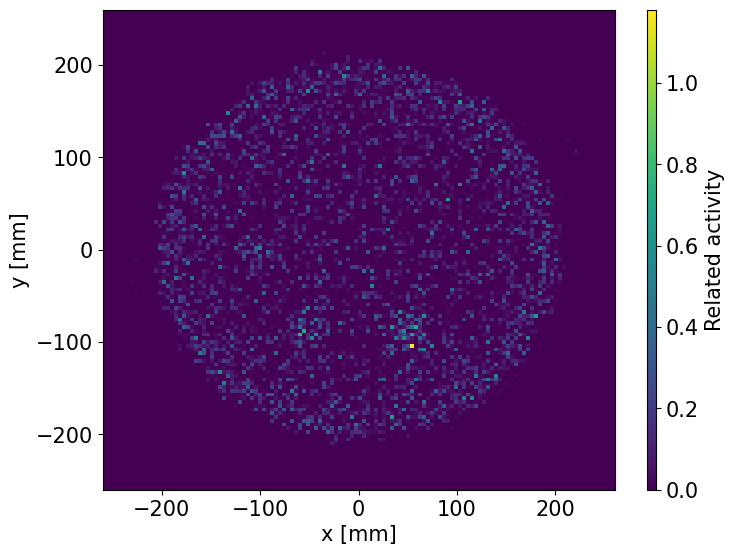

100%|██████████| 50/50 [00:09<00:00,  5.29it/s]


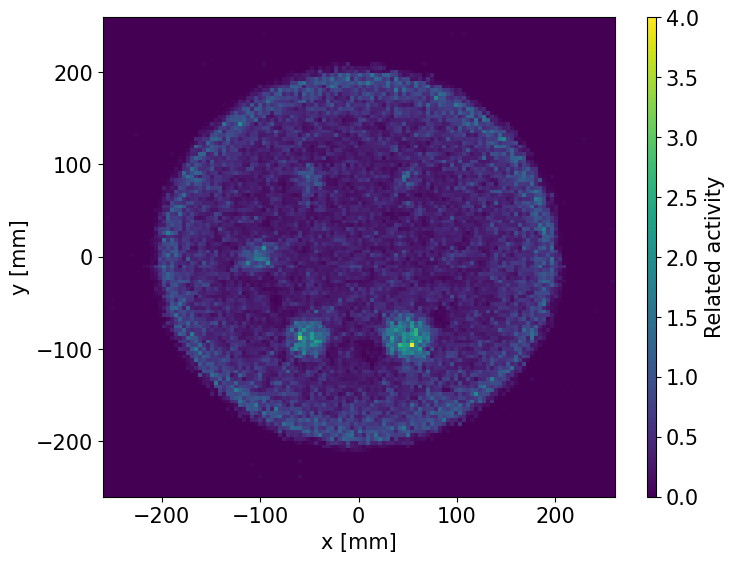

100%|██████████| 200/200 [00:37<00:00,  5.28it/s]


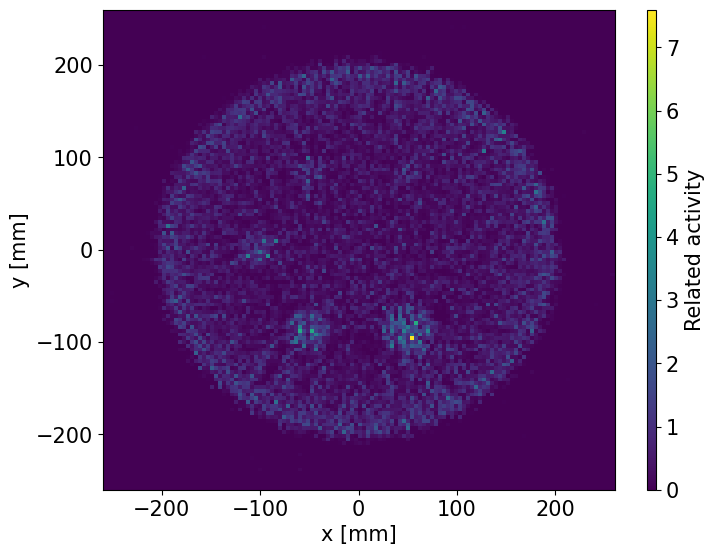

100%|██████████| 50/50 [00:09<00:00,  5.18it/s]


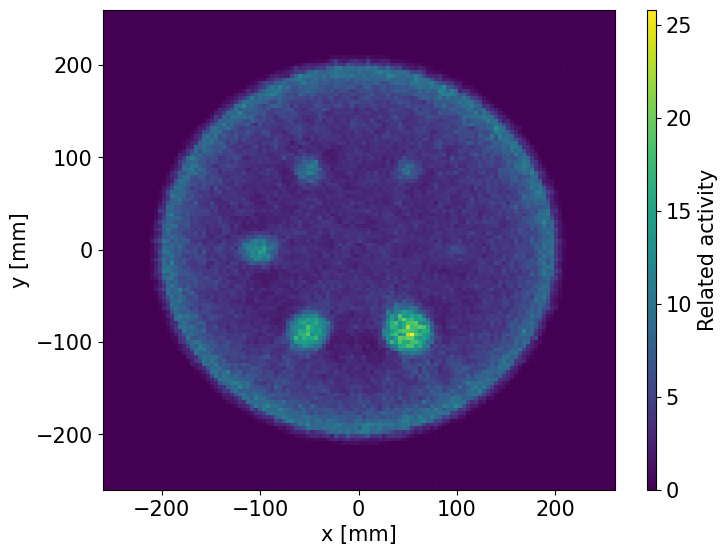

100%|██████████| 200/200 [00:37<00:00,  5.29it/s]


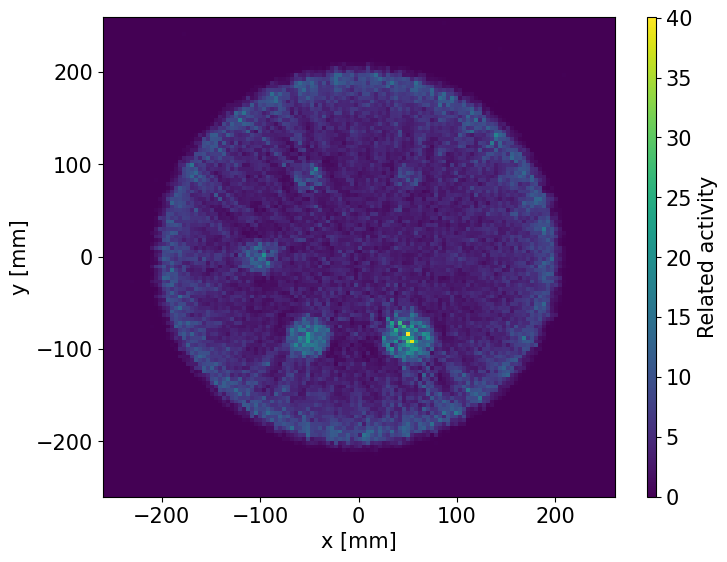

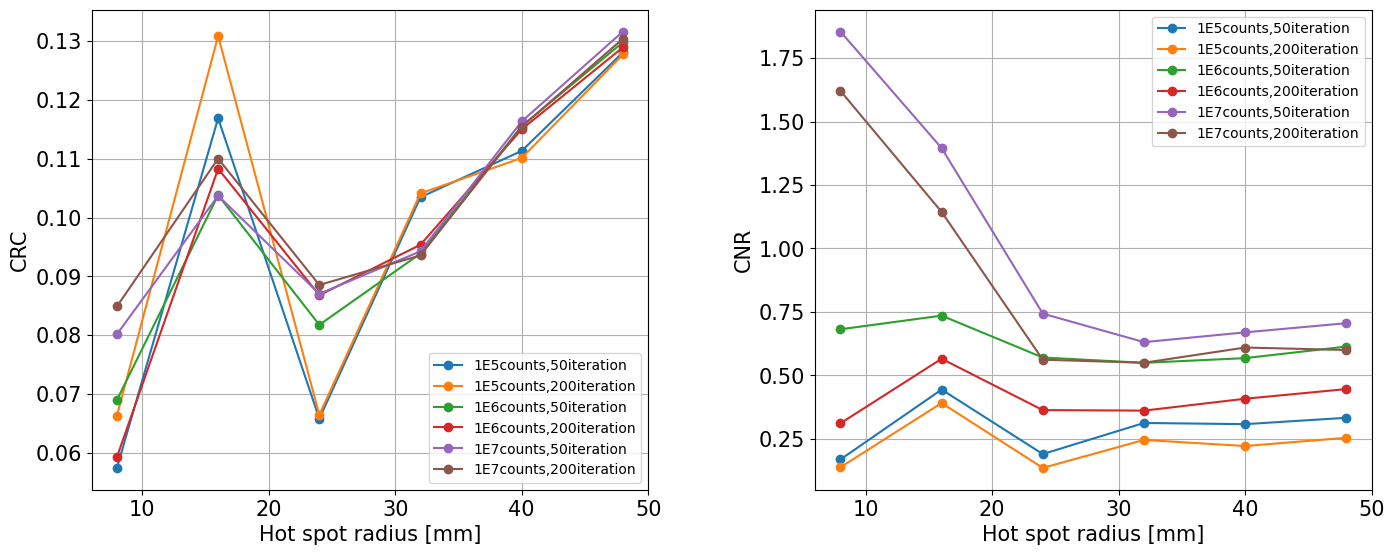

In [22]:
CRC_llist = []
CNR_llist = []

m = trans_matrix(method='Siddon')

counts = [5, 6, 7]
iter_list = [50, 200]

for ci in counts:
    p = np.fromfile('Proj_1e{}Counts'.format(ci), dtype=np.float32)
    CRC_list = []
    CNR_list = []
    L = L_list[4]
    for ci in iter_list:
        f_list, d_list = osem(p, m, ci, L)
        gray = f_list[-1].reshape((image['pixels'], image['pixels']))[::-1, ::-1]

        CRC_list.append(CRC(gray))
        CNR_list.append(CNR(gray))

        fig = plt.figure(figsize=(8, 6))
        # fig.tight_layout()
        gs = gridspec.GridSpec(1, 1, figure=fig, left=0.15, right=0.95, top=0.95, bottom=0.15, wspace=0.3, hspace=0.3)
        ax = fig.add_subplot(gs[0, 0])
        pc = ax.pcolormesh(X_pixels, Y_pixels, gray, shading='auto')
        c = fig.colorbar(pc, ax=ax, aspect=50)
        c.ax.set_ylabel('Related activity')
        ax.set_xlabel('x [mm]')
        ax.set_ylabel('y [mm]')

        plt.show()
    CRC_llist.append(CRC_list)
    CNR_llist.append(CNR_list)

fig = plt.figure(figsize=(16, 6))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 2, figure=fig, left=0.15, right=0.95, top=0.95, bottom=0.15, wspace=0.3, hspace=0.3)
ax = fig.add_subplot(gs[0, 0])
for i, (ci, color) in enumerate(zip(counts, ['r', 'g', 'b'])):
    CRC_list = CRC_llist[i]
    for j, (it, s) in enumerate(zip(iter_list, ['o--', 'o-'])):
        ax.plot(hotr, CRC_list[j], s, color=color, label='1E{}counts,{}iteration'.format(ci, it))
ax.grid()
ax.set_xlabel('Hot spot radius [mm]')
ax.set_ylabel('CRC')
ax.legend(fontsize=10)

ax = fig.add_subplot(gs[0, 1])
for i, (ci, color) in enumerate(zip(counts, ['r', 'g', 'b'])):
    CNR_list = CNR_llist[i]
    for j, (it, s) in enumerate(zip(iter_list, ['o--', 'o-'])):
        ax.plot(hotr, CNR_list[j], s, color=color, label='1E{}counts,{}iteration'.format(ci, it))
ax.grid()
ax.set_xlabel('Hot spot radius [mm]')
ax.set_ylabel('CNR')
ax.legend(fontsize=10)

fig.savefig('img/C7-count-iter-crccnr.png')

plt.show()